In [1]:
## Importing necessary libraries
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import normalize

In [2]:
cust_data = pd.read_csv("../data/customer_data.csv")

In [3]:
cust_data.describe()

,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,133.798917,21.560731,224.903868,371.234784,85.985401,88.463386
std,132.735229,19.285931,305.002619,501.708956,215.913912,98.735861
min,0.000000,1.000000,1.000000,0.850000,1.000000,0.000000
25%,0.000000,9.041667,90.583333,174.022000,16.000000,15.500000
50%,101.000000,16.500000,158.235294,283.120000,39.000000,46.000000
75%,257.000000,28.000000,265.483333,419.060500,94.000000,134.000000
max,373.000000,300.647059,7824.000000,14844.766667,7499.000000,373.000000


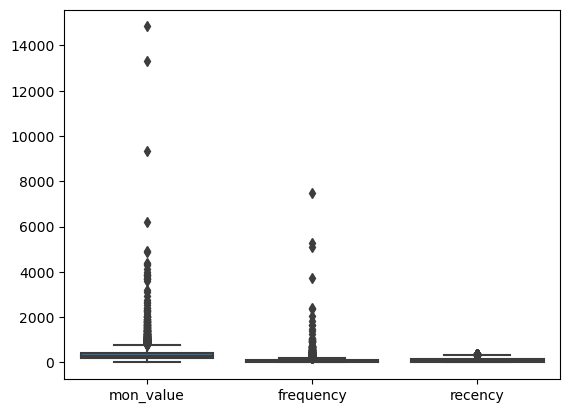

In [4]:
# Let's check the distribution of the RFM attributes
sns.boxplot(cust_data[['mon_value', 'frequency', 'recency']]);

#### It is shown in the plot above that the scales from the three main attributes of the RFM analysis are quite different. As next step, I will normalize them in order to be able to use them to calculate the RFM score

In [5]:
for col in cust_data:
    if col == 'customer_id':
        pass
    else:
        norm = normalize(cust_data[f"{col}"])
        col_name = col + "_norm"
        cust_data[f"{col_name}"] = norm

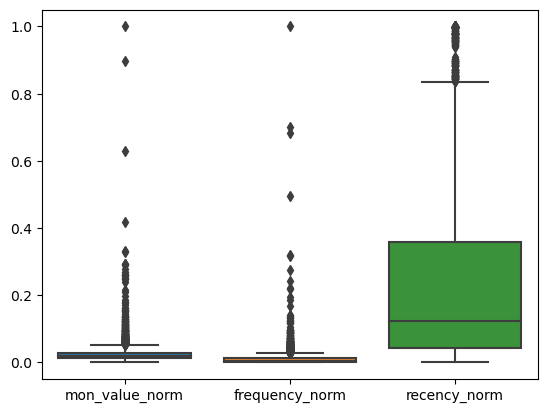

In [6]:
# Let's check the distribution of the RFM attributes this time normalized
sns.boxplot(cust_data[['mon_value_norm', 'frequency_norm', 'recency_norm']]);

#### Monetary value and Frequency are having quite a lot of outliers, they are less spread through the range than Recency. I will define my RFM score as: 

$RFM_{score} = W_{recency} * Recency + W_{frequency} * Frequency + W_{monetary} * Monetary $

$W_{recency}$, $W_{frequency}$ and $W_{monetary}$ will represent the respectively contribution of each attribute to the RFM score.

> <div class="alert alert-block alert-success">
<b>Assumption: </b>Since my data contain transactions puchased on a year, the recency will not be consider as important as the frequency or the monetary value. I will assume that my data comes from transactions on a establish e-commerce, therefore I will focus on the segmentation of my customers giving an extra importance to the monetary value.
</div>

In [7]:
def cust_seg(data, W_R, W_F, W_M):
    # Function to obtain the customers' segments 
    # cust_data is a pandas data frame that contains "recency_norm", "frequency_norm" and mon_value_norm"
    # This are the normalized version of the recency, frequency and monetary value per customer
    # W_R, W_F, W_M are the weights for each attribute
    
    RFM_score = W_R * data['recency_norm'] + W_F * data['frequency_norm'] + W_M * data['mon_value_norm']
    data['RFM_score'] = RFM_score # adding RFM score to the customer dataset
    
    segment = []
    Q1, Q2, Q3 = RFM_score.quantile([0.25, .50, 0.75])
    
    for score in RFM_score:
        if score <= Q1:
            segment.append(1)
        elif Q1 < score <= Q2:
            segment.append(2)
        elif Q2 < score <= Q3:
            segment.append(3)
        else:
            segment.append(4)

    data['cust_segment'] = segment
    
    return data

In [8]:
cust_seg(cust_data, 0.6, 0.1, 0.3)

,customer_id,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency,loyalty_time_norm,mean_nstock_norm,mean_nitem_norm,mon_value_norm,frequency_norm,recency_norm,RFM_score,cust_segment
0,u12347,365,26.000000,351.142857,615.714286,182.0,1,0.978552,0.083431,0.044758,0.041422,0.024140,0.002681,0.016449,1
1,u12348,282,6.750000,583.000000,359.310000,27.0,74,0.756032,0.019189,0.074396,0.024149,0.003468,0.198391,0.126626,3
2,u12349,0,72.000000,630.000000,1457.550000,72.0,18,0.000000,0.236945,0.080404,0.098134,0.009469,0.048257,0.059342,2
3,u1235,0,16.000000,196.000000,294.400000,16.0,309,0.000000,0.050059,0.024926,0.019776,0.002001,0.828418,0.503184,4
4,u12352,260,11.000000,75.142857,197.962857,77.0,35,0.697051,0.033373,0.009478,0.013279,0.010136,0.093834,0.061298,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,u1828,0,10.000000,45.000000,180.600000,10.0,277,0.000000,0.030035,0.005624,0.012109,0.001200,0.742627,0.449329,4
4243,u18281,0,7.000000,54.000000,80.820000,7.0,180,0.000000,0.020024,0.006775,0.005387,0.000800,0.482574,0.291240,4
4244,u18282,114,6.000000,51.500000,89.025000,12.0,7,0.305630,0.016686,0.006455,0.005940,0.001467,0.018767,0.013189,1
4245,u18283,333,44.937500,84.687500,127.473750,719.0,3,0.892761,0.146631,0.010698,0.008530,0.095759,0.008043,0.016961,1


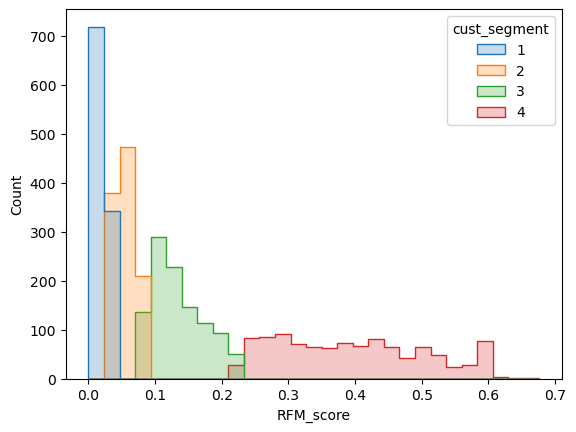

In [9]:
p = sns.histplot(data=cust_data, x='RFM_score', hue='cust_segment', element="step", palette="tab10")

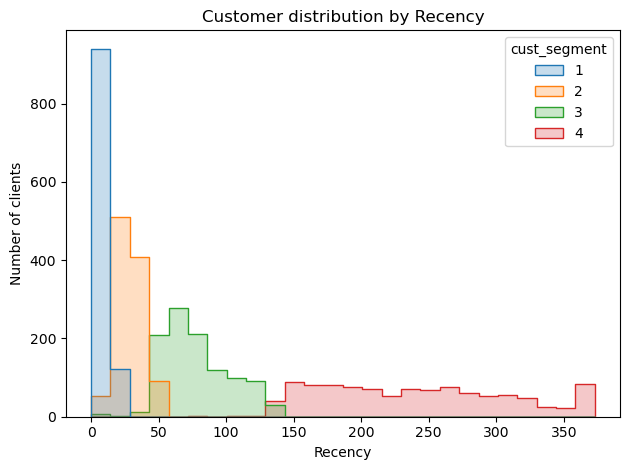

In [10]:
# Customer distribution by recency and segment
sns.histplot(data=cust_data, x='recency', hue='cust_segment', element="step", palette="tab10")
plt.title("Customer distribution by Recency")
plt.xlabel("Recency")
plt.ylabel("Number of clients")
plt.tight_layout()

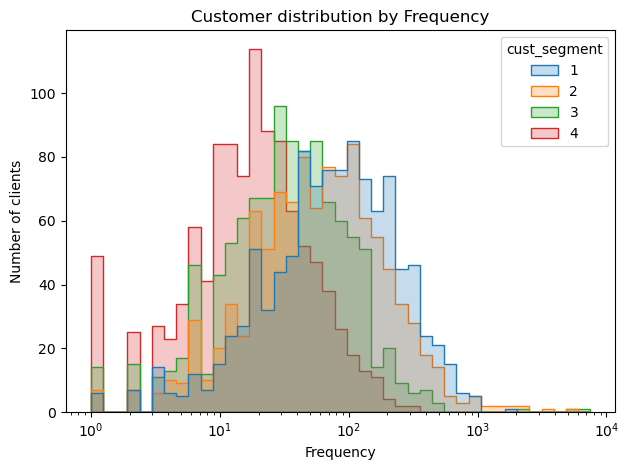

In [11]:
# Customer distribution by frequency and segment
sns.histplot(data=cust_data, x='frequency', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of clients")
plt.tight_layout()

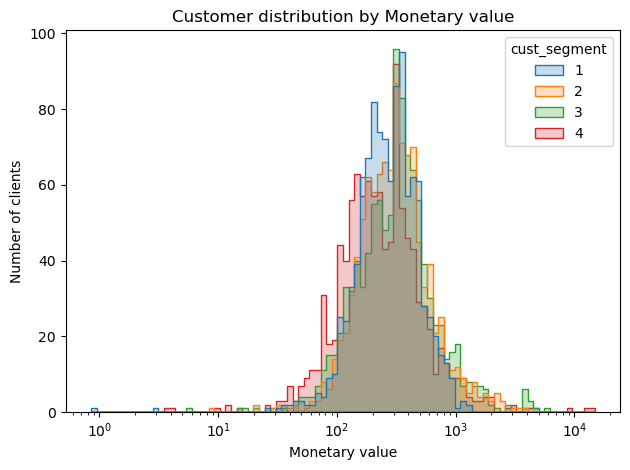

In [12]:
# Customer distribution by monetary value and segment
sns.histplot(data=cust_data, x='mon_value', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Monetary value")
plt.xlabel("Monetary value")
plt.ylabel("Number of clients")
plt.tight_layout()

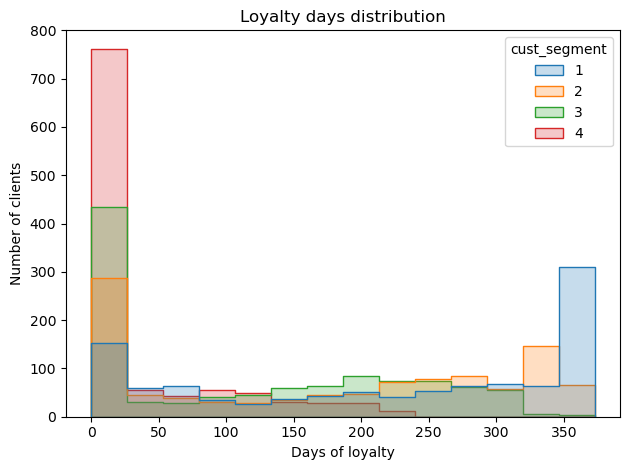

In [13]:
sns.histplot(data=cust_data, x='loyalty_time', hue='cust_segment', element="step", palette="tab10")
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
plt.tight_layout()

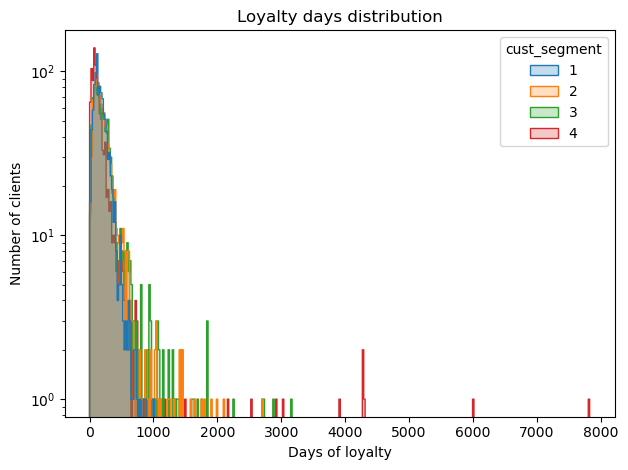

In [14]:
p = sns.histplot(data=cust_data, x='mean_nitem', hue='cust_segment', element="step", palette="tab10")
plt.title("Loyalty days distribution")
plt.xlabel("Days of loyalty")
plt.ylabel("Number of clients")
p.set_yscale('log')
plt.tight_layout()

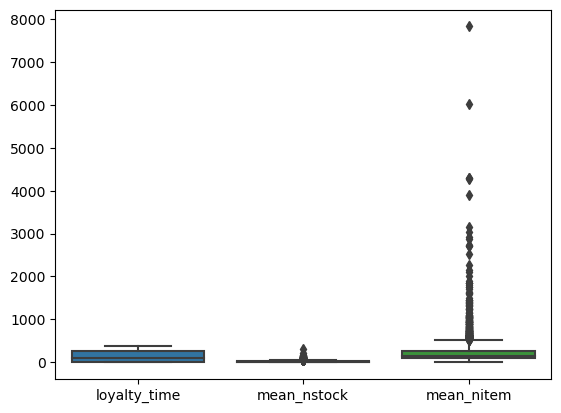

In [16]:
# Let's check the distribution of the rest of my attributes
sns.boxplot(cust_data[['loyalty_time', 'mean_nstock', 'mean_nitem']]);

In [19]:
cols_to_drop = cust_data.iloc[:, 4:]
other_custdata = cust_data.drop(cols_to_drop, axis=1).rename(columns={'loyalty_time': 'recency', 'mean_nstock': 'frequency', 'mean_nitem': 'mon_value'})

In [20]:
for col in other_custdata:
    if col == 'customer_id':
        pass
    else:
        norm = normalize(other_custdata[f"{col}"])
        col_name = col + "_norm"
        other_custdata[f"{col_name}"] = norm

In [24]:
other_custdata.columns

Index(['customer_id', 'recency', 'frequency', 'mon_value', 'recency_norm',
       'frequency_norm', 'mon_value_norm', 'RFM_score', 'cust_segment'],
      dtype='object')

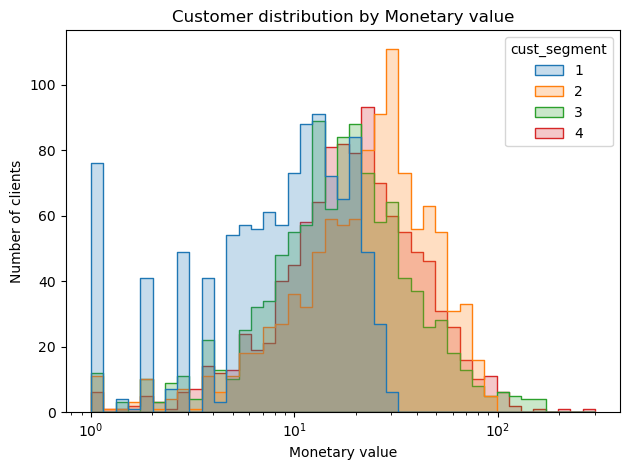

In [30]:
# Customer distribution by monetary value and segment
sns.histplot(data=other_custdata, x='frequency', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Monetary value")
plt.xlabel("Monetary value")
plt.ylabel("Number of clients")
plt.tight_layout()